In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In [2]:
import cv2

In [2]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [6]:
def categorize(value):
    if 0 <= value <= 25:
        return 0
    elif 25 < value <= 40:
        return 1
    else:
        return 2

def add_categories():
    file_path = '../output/training_data/train.csv'
    df = pd.read_csv(file_path)
    # Apply the categorize function to the numerical column and create a new column
    df['Category'] = df['num_triangles'].apply(categorize)

    # Save the DataFrame with the new column back to a CSV file
    df.to_csv('../output_file.csv', index=False)

In [3]:
def remove_white_images_without_neigbour(row):
    if (row['neighbours'] == 0) & (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True
    
def remove_white_images(row):
    if (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True

In [4]:
# Load your CSV file containing image names, features, and labels
data = pd.read_csv('../output/training_data/train.csv')

In [ ]:
data.head()

In [ ]:
data[data['len_of_boundry_per_100px'] == 0]

In [7]:
data['density_category'] = data['triangle_per_100px'].apply(categorize)
data.head()

,name,len_of_boundry,len_of_boundry_inv,disjoint_image,tile_size,num_triangles,image_category,triangle_per_100px,density_category,neighbours,len_of_boundry_per_100px
0,branch_line_coupler_0_250_0_0.png,996.0,0.0,0,250,7,0,1.12,0,0,0.0
1,branch_line_coupler_0_250_0_1.png,996.0,0.0,0,250,58,0,9.28,0,2,0.0
2,branch_line_coupler_0_250_0_2.png,1050.0,938.0,1,250,235,2,37.60,1,2,375.2
3,branch_line_coupler_0_250_0_3.png,996.0,0.0,0,250,51,0,8.16,0,4,0.0
4,branch_line_coupler_0_250_0_4.png,996.0,0.0,0,250,14,0,2.24,0,4,0.0


In [14]:
data.shape

(6274, 11)

In [5]:
data = data[data.apply(remove_white_images, axis=1)]
data.shape

(4693, 11)

In [172]:
data = data[data['density_category'].isin([0,2])]
data['density_category'] = np.where(data['density_category'] == 2, 1, 0)

In [32]:
#data[(data['triangle_per_100px'] > 25) & (data['triangle_per_100px'] <= 40)  & (data['density_category'] == 1)]
#data[(data['triangle_per_100px'] > 25) & (data['triangle_per_100px'] < 50)  & (data['triangle_per_100px'] >= 40) & (data['density_category'] == 1)]
data[(data['triangle_per_100px'] <= 25) & (data['density_category'] == 0)]
#data[(data['triangle_per_100px'] > 40) & (data['density_category'] == 2)]

,name,len_of_boundry,len_of_boundry_inv,disjoint_image,tile_size,num_triangles,image_category,triangle_per_100px,density_category,neighbours,len_of_boundry_per_100px
0,branch_line_coupler_0_250_0_0.png,996.000000,0.000000,0,250,7,0,1.12,0,0,0.000000
1,branch_line_coupler_0_250_0_1.png,996.000000,0.000000,0,250,58,0,9.28,0,2,0.000000
3,branch_line_coupler_0_250_0_3.png,996.000000,0.000000,0,250,51,0,8.16,0,4,0.000000
4,branch_line_coupler_0_250_0_4.png,996.000000,0.000000,0,250,14,0,2.24,0,4,0.000000
6,branch_line_coupler_0_250_0_6.png,742.000000,750.000000,1,250,143,1,22.88,0,3,300.000000
...,...,...,...,...,...,...,...,...,...,...,...
6267,planar_filter_95_250_6_7.png,996.000000,0.000000,0,250,4,0,0.64,0,2,0.000000
6270,planar_filter_95_500_1_3.png,2822.062013,2869.754396,1,500,409,2,16.36,0,3,573.950879
6271,planar_filter_95_500_2_1.png,3300.553391,1038.208151,3,500,504,2,20.16,0,3,207.641630
6272,planar_filter_95_500_2_2.png,3012.724963,2617.043719,2,500,564,2,22.56,0,5,523.408744


In [6]:
import seaborn as sns
import matplotlib as plt

In [ ]:
sns.histplot(data=data, x='triangle_per_100px')

In [44]:
data.shape

(4693, 11)

In [9]:
# Function to apply Sobel filter to an image
def apply_sobel(image):
    # Your Sobel filter implementation
    # For example:
    sobel_image = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=3)
    return sobel_image

In [7]:
# Load and preprocess black and white images
image_data = []
for image_file in data['name']:
    image = load_img('../output/tiles/' + image_file, color_mode='grayscale', target_size=(64, 64))
    image = img_to_array(image)
    image /= 255.0  # Normalize pixel values
    # Apply Sobel filter
    #sobel_image = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=3)
    
    # Optionally, you might want to normalize the Sobel image as well
    #sobel_image /= np.max(np.abs(sobel_image))
    image_data.append(image)

image_data = np.array(image_data)

In [8]:
# Load numerical features and one-hot encode labels
#features = data[['len_of_boundry_inv', 'disjoint_image']].values
features = data[['len_of_boundry_per_100px', 'disjoint_image', 'neighbours']].values
labels = data['density_category'].values

# One-hot encode labels
labels = to_categorical(labels)

# Convert labels to binary format
#labels_binary = (labels == 1).astype(int)  # Assuming 1 is the positive class



In [ ]:
labels_binary

In [20]:
num_classes = len(set(data['image_category'].values))
print(labels.shape)

(4693, 3)


In [21]:
noc = features.shape[1]

In [81]:
df = pd.DataFrame(labels)

# Check which columns have all zero values
all_zero_columns = df.columns[(df == 0).all()]
df = df.drop(all_zero_columns, axis=1)
print(all_zero_columns)

all_zero_after = df.columns[(df == 0).all()]
print(all_zero_after)

Index([], dtype='int64')
Index([], dtype='int64')


In [9]:
from sklearn.preprocessing import RobustScaler

In [10]:
robust_scaler = RobustScaler()
features = robust_scaler.fit_transform(features)

In [221]:
# Split the data into training, validation, and test sets for images
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Split the data into training, validation, and test sets for features
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

In [183]:
# Split the data into training, validation, and test sets for images and features
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_binary, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels_binary, test_size=0.2, random_state=42)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)


In [34]:
def printshape(val):
    for v in val:
        print(v.shape)

In [ ]:
printshape([X_train, X_test, X_val])
printshape([y_train, y_test, y_val])
printshape([features_train, features_test, features_val])
printshape([labels_train, labels_test, labels_val])

In [105]:
# Define the input layers
image_input = Input(shape=(224, 224, 1))
feature_input = Input(shape=(2,))

In [274]:
def create_model():
    # Define the input layers
    image_input = Input(shape=(64, 64, 1))
    feature_input = Input(shape=(features.shape[1],))

    # CNN for processing images
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(image_input)
    x = BatchNormalization()(conv1)
    x = Dropout(0.2)(x)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(x)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
    x = BatchNormalization()(conv2)
    x = Dropout(0.2)(x)
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(x)
    flatten = Flatten()(maxpool2)

    # Dense network for processing features
    dense1 = Dense(32, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(32, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
#Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In [280]:
model = create_model()
#model.summary()

In [281]:
history = model.fit([X_train, features_train], y_train, epochs=15, batch_size=32, validation_data=([X_val, features_val], y_val))

Epoch 1/15
94/94 [==============================] - 3s 20ms/step - loss: 1.1044 - accuracy: 0.4972 - val_loss: 1.0463 - val_accuracy: 0.4554
Epoch 2/15
94/94 [==============================] - 2s 17ms/step - loss: 0.9322 - accuracy: 0.5624 - val_loss: 1.2849 - val_accuracy: 0.4541
Epoch 3/15
94/94 [==============================] - 2s 17ms/step - loss: 0.9065 - accuracy: 0.5741 - val_loss: 1.3625 - val_accuracy: 0.4434
Epoch 4/15
94/94 [==============================] - 2s 16ms/step - loss: 0.8670 - accuracy: 0.5961 - val_loss: 1.1626 - val_accuracy: 0.5686
Epoch 5/15
94/94 [==============================] - 2s 17ms/step - loss: 0.8436 - accuracy: 0.6167 - val_loss: 1.0944 - val_accuracy: 0.5459
Epoch 6/15
94/94 [==============================] - 2s 17ms/step - loss: 0.8348 - accuracy: 0.6154 - val_loss: 1.0201 - val_accuracy: 0.5806
Epoch 7/15
94/94 [==============================] - 2s 17ms/step - loss: 0.8065 - accuracy: 0.6454 - val_loss: 0.9764 - val_accuracy: 0.5766
Epoch 8/15
94

In [200]:
def showDetails(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

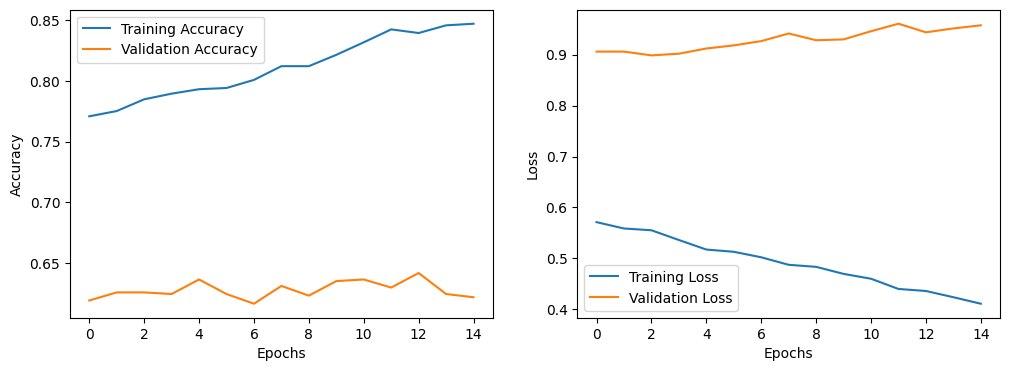

In [279]:
showDetails(history)

In [251]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')

30/30 [==============================] - 0s 9ms/step - loss: 2.6466 - accuracy: 0.4579
Test accuracy: 0.4579339623451233


In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your true and predicted labels
# Get true labels
y_true = y_test

# Get predicted probabilities
Y_pred = model.predict([X_test, features_test])

# Get predicted class indices
y_pred = np.argmax(Y_pred, axis=1)




18/18 [==============================] - 0s 6ms/step


In [56]:
print(y_true[0])

[1. 0. 0.]


In [1]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,2])
disp.plot(cmap='Blues', values_format='d')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [23]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("functional_model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())

## Cross Entropy

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [43]:
accuracy = []
model_history = []
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    features_train_fold, features_val_fold = features_train[train_index], features_train[test_index]
    labels_train_fold, labels_val_fold = labels_train[train_index], labels_train[test_index]

    # Create and compile your CNN model
    model = create_model()

    # Train the model on the current fold
    history = model.fit([X_train_fold, features_train_fold], y_train_fold, epochs=10, batch_size=32, validation_data=([X_val_fold, features_val_fold], y_val_fold))
    #model.fit([X_train, features_train], y_train, validation_data=([X_val, features_val], y_val), epochs=20)

    # Evaluate the model on the test set of the current fold
    test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
    print(f'Test accuracy for current fold: {test_accuracy}')
    accuracy.append(test_accuracy)
    model_history.append(history)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [32]:
print(accuracy)
print(np.average(accuracy))

[0.5516507029533386, 0.5623003244400024, 0.5452609062194824, 0.5441959500312805, 0.5069222450256348]
0.5420660257339478


In [25]:
def showDetails(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

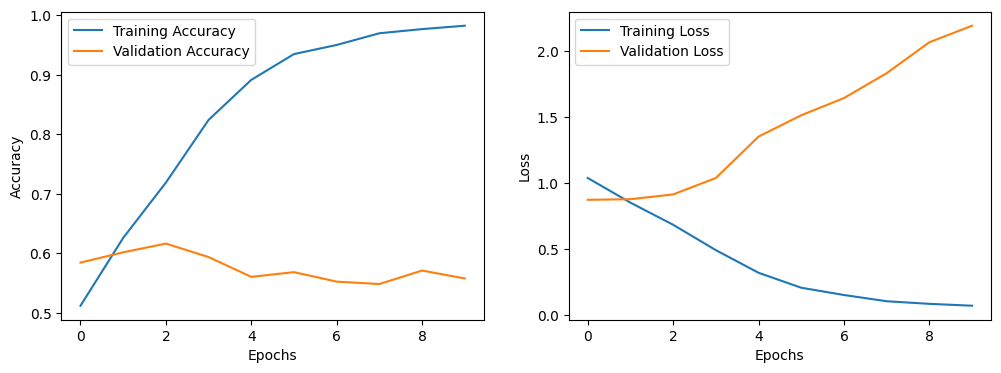

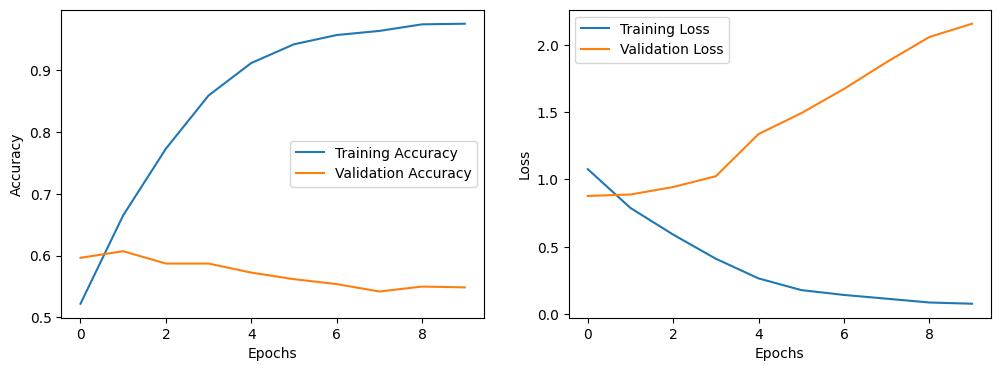

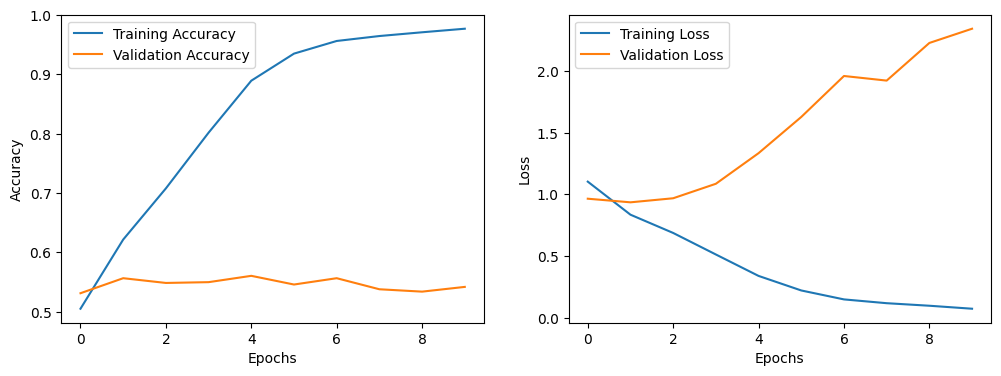

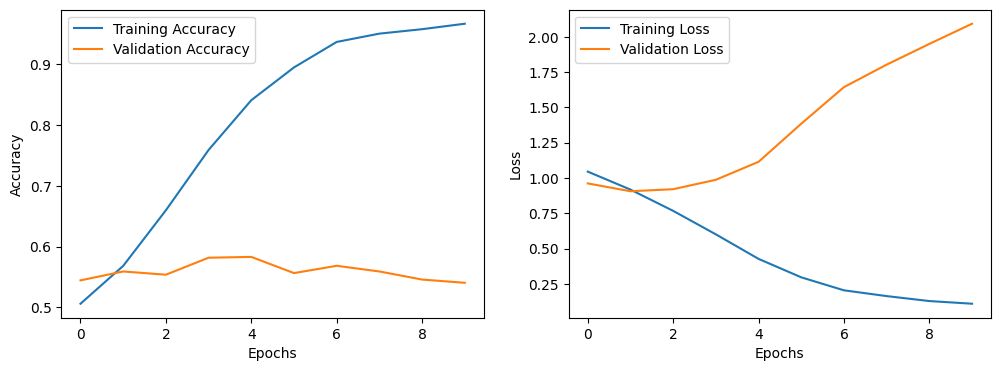

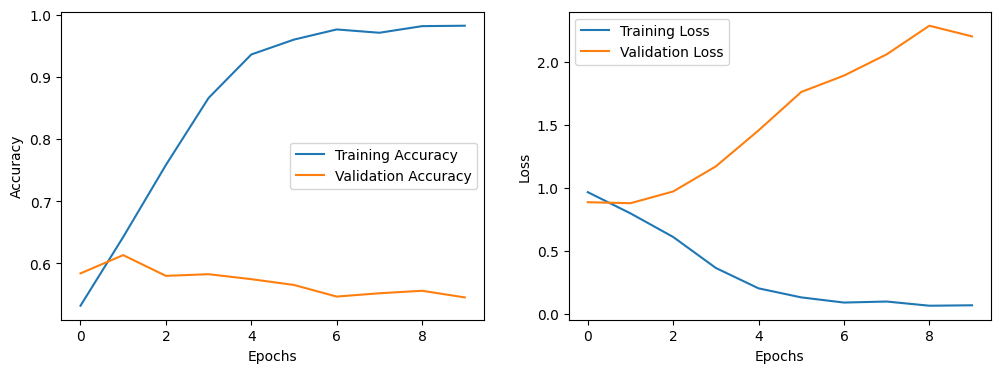

In [33]:
for history in model_history:
    showDetails(history)

## Hyper parameter tuning

In [44]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dropout, BatchNormalization

In [45]:
def create_model_tuning(learning_rate = 0.001, num_layers=1, num_filters = 16):
    # Define the input layers
    #image_input, feature_input = inputs
    image_input = Input(shape=(224, 224, 1))
    feature_input = Input(shape=(noc,))

    # CNN for processing images
    # conv1 = Conv2D(16, (3, 3), activation='relu')(image_input)
    # maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # conv2 = Conv2D(16, (3, 3), activation='relu')(maxpool1)
    # maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # flatten = Flatten()(maxpool1)

    x = image_input
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu')(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.4)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    flatten = Flatten()(x)

    # Dense network for processing features
    dense1 = Dense(num_filters, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(32, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [46]:
# Wrapper function for multiple inputs
def create_cnn_model_wrapper(learning_rate=0.001, num_layers=3, num_filters=64):
    # Assuming you have a function that creates your CNN model with multiple inputs
    model = create_model_tuning(learning_rate=learning_rate, num_layers=num_layers, num_filters=num_filters)
    return model

In [47]:
model = create_model_tuning()
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 222, 222, 16  160         ['input_47[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_44 (MaxPooling2D  (None, 111, 111, 16  0          ['conv2d_44[0][0]']              
 )                              )                                                          

In [48]:
cnn_model = KerasClassifier(build_fn=create_model_tuning, epochs=10, batch_size=32, verbose=0)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_layers': [1, 2, 3],
    'num_filters': [16, 32, 48]
}

#grid = GridSearchCV(estimator=cnn_model, param_grid=param_grid, cv=5, scoring='accuracy')
random_search = RandomizedSearchCV(estimator=cnn_model, param_distributions=param_grid, n_iter=10, cv=5)

In [99]:
print('X_train : ', X_train.shape)
print('features_train : ', features_train.shape)
print('y_train : ', y_train.shape)

X_train :  (4899, 224, 224, 1)
features_train :  (4899, 3)
y_train :  (4899, 3)


In [ ]:
#combined_X_train = np.stack([X_train, features_train], axis=-1)
#grid_result = grid.fit(combined_X_train, y_train)
grid_result = grid.fit([X_train, features_train], y_train)

In [ ]:
random_search_result = random_search.fit([X_train, features_train], y_train)

## Optuna

In [11]:
def create_model_optuna(trial, noc, learning_rate, num_filters, num_layers, batch_norm, drop_out=0):

    # Define the input layers
    #image_input, feature_input = inputs
    image_input = Input(shape=(64, 64, 1))
    feature_input = Input(shape=(noc,))


    x = image_input
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        if drop_out > 0:
            x = Dropout(drop_out)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    flatten = Flatten()(x)

    # Dense network for processing features
    dense1 = Dense(num_filters, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(64, activation='relu')(merged)
    output = Dense(3, activation='softmax')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [12]:
import optuna
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In [15]:
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif name == 'adagrad':
        return Adagrad(learning_rate=learning_rate)
    elif name == 'adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif name == 'adamax':
        return Adamax(learning_rate=learning_rate)
    elif name == 'nadam':
        return Nadam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

In [13]:
def objective(trial):
    image_shape = (224, 224, 1)  # Adjust based on your image dimensions
    noc = 3  # Number of features

    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    num_filters = trial.suggest_categorical('num_filters', [16, 32])
    num_layers = trial.suggest_int('num_layers', 1, 2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [10, 15, 20])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    drop_out = trial.suggest_categorical('drop_out', [0.1, 0.2, 0.3])


    model = create_model_optuna(trial, noc, learning_rate, num_filters, num_layers, batch_norm, drop_out=drop_out)

    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Split the data into training and validation sets
    X_train, X_val, features_train, features_val, y_train, y_val = train_test_split(
        image_data, features, labels, test_size=0.2, random_state=0
    )

    # Train the model
    history = model.fit(
        [X_train, features_train], y_train,
        validation_data=([X_val, features_val], y_val),
        epochs=epochs, batch_size=batch_size, verbose=0
    )

    # Return the validation accuracy for Optuna to optimize
    return history.history['val_accuracy'][-1]

In [16]:
# with more hyper parameter
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-01-19 03:09:56,822] A new study created in memory with name: no-name-126ac04b-7585-49e9-9920-751dd9ad05ec
[I 2024-01-19 03:10:11,894] Trial 0 finished with value: 0.530351459980011 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'sgd', 'batch_norm': False, 'drop_out': 0.3}. Best is trial 0 with value: 0.530351459980011.
[I 2024-01-19 03:10:23,532] Trial 1 finished with value: 0.5644302368164062 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 1, 'batch_size': 64, 'epochs': 15, 'optimizer': 'adadelta', 'batch_norm': False, 'drop_out': 0.1}. Best is trial 1 with value: 0.5644302368164062.
[I 2024-01-19 03:10:37,324] Trial 2 finished with value: 0.35463258624076843 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 1, 'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'batch_norm': True, 'drop_out': 0.2}. Best is trial 1 with value: 0.5644302368164062.
[I 2024-0

Best trial:
Accuracy: 0.6304579377174377
Best hyperparameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 2, 'batch_size': 16, 'epochs': 10, 'optimizer': 'nadam', 'batch_norm': False, 'drop_out': 0.2}


In [25]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

#plt.figure(figsize=(12, 4))
fig = plot_optimization_history(study)
# Set the size of the figure
fig.update_layout(width=800, height=400)

# Set font size
fig.update_layout(font=dict(size=18))
fig.show(config=plotly_config)

In [26]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

In [39]:
# with white images
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-11 13:37:35,663] A new study created in memory with name: no-name-fd7337be-1209-4f48-87ce-b4b0ee63b1be
[I 2023-12-11 13:37:59,477] Trial 0 finished with value: 0.7363265156745911 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7363265156745911.
[I 2023-12-11 13:38:30,296] Trial 1 finished with value: 0.7477551102638245 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2}. Best is trial 1 with value: 0.7477551102638245.
[I 2023-12-11 13:38:57,265] Trial 2 finished with value: 0.7518367171287537 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 1}. Best is trial 2 with value: 0.7518367171287537.
[I 2023-12-11 13:39:24,606] Trial 3 finished with value: 0.7591836452484131 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 1}. Best is trial 3 with value: 0.7591836452484131.
[I 2023-12-11 13:39:51,684] Trial 4 finished with value: 0.7591836452484131 and 

Best trial:
Accuracy: 0.76816326379776
Best hyperparameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 1}


In [23]:

# without white images
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-11 13:02:16,900] A new study created in memory with name: no-name-bbcc3b3e-8bae-493c-9646-cf2acab3751a
[I 2023-12-11 13:02:33,822] Trial 0 finished with value: 0.7273695468902588 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:02:54,236] Trial 1 finished with value: 0.7028753757476807 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 2}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:03:18,361] Trial 2 finished with value: 0.690095841884613 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 2}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:03:35,968] Trial 3 finished with value: 0.7188498377799988 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1}. Best is trial 0 with value: 0.7273695468902588.
[I 2023-12-11 13:03:59,827] Trial 4 finished with value: 0.6624068021774292 and par

Best trial:
Accuracy: -0.7454739212989807
Best hyperparameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1}


In [125]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [59]:
model = create_model()

In [ ]:
model.summary()

In [60]:
# Train the model
history = model.fit([X_train, features_train], y_train, validation_data=([X_val, features_val], y_val), epochs=20)

Epoch 1/20
78/78 [==============================] - 3s 25ms/step - loss: 4.9668 - accuracy: 0.4876 - val_loss: 1.2176 - val_accuracy: 0.4425
Epoch 2/20
78/78 [==============================] - 2s 19ms/step - loss: 0.8182 - accuracy: 0.6283 - val_loss: 0.9743 - val_accuracy: 0.5851
Epoch 3/20
78/78 [==============================] - 2s 20ms/step - loss: 0.7066 - accuracy: 0.6944 - val_loss: 0.8768 - val_accuracy: 0.6207
Epoch 4/20
78/78 [==============================] - 2s 20ms/step - loss: 0.5905 - accuracy: 0.7426 - val_loss: 0.8608 - val_accuracy: 0.6775
Epoch 5/20
78/78 [==============================] - 2s 19ms/step - loss: 0.4721 - accuracy: 0.8253 - val_loss: 0.8765 - val_accuracy: 0.6499
Epoch 6/20
78/78 [==============================] - 2s 20ms/step - loss: 0.3970 - accuracy: 0.8602 - val_loss: 0.9314 - val_accuracy: 0.6207
Epoch 7/20
78/78 [==============================] - 2s 20ms/step - loss: 0.3391 - accuracy: 0.8877 - val_loss: 0.9559 - val_accuracy: 0.6613
Epoch 8/20
78

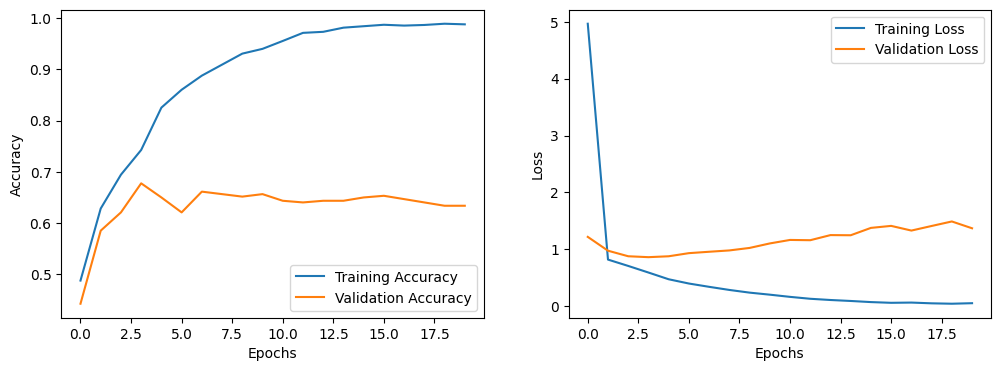

In [61]:
# without neighbouring borders for white images
showDetails(history)

In [24]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')


34/34 [==============================] - 0s 10ms/step - loss: 1.5015 - accuracy: 0.6749
Test accuracy: 0.6748582124710083


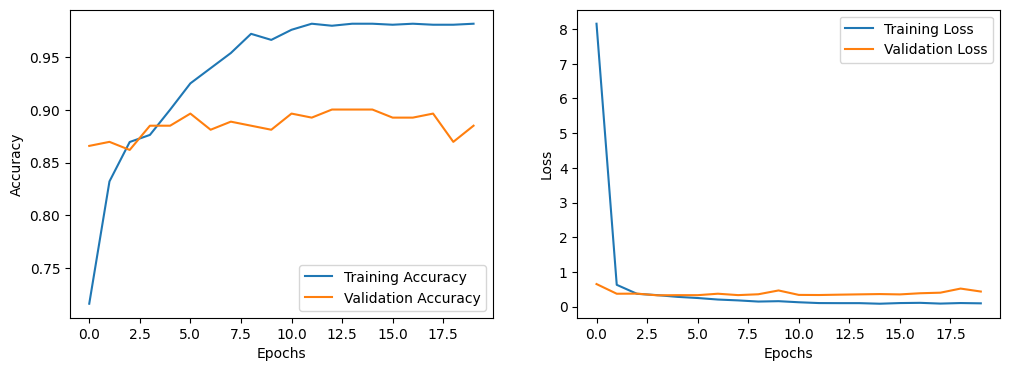

In [73]:
# with neighbouring borders for white images
showDetails(history)

In [74]:
test_loss, test_accuracy = model.evaluate([X_test, features_test], y_test)
print(f'Test accuracy: {test_accuracy}')

11/11 [==============================] - 0s 9ms/step - loss: 0.5352 - accuracy: 0.8349
Test accuracy: 0.8348624110221863


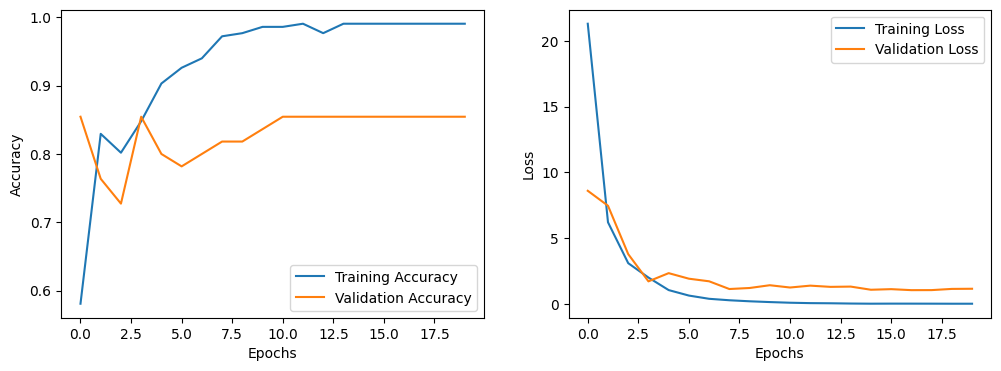

In [61]:
showDetails(history)

In [14]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())


In [21]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()